# ProtoSelect on Adult Census and CIFAR10

[Bien and Tibshirani (2012)](https://arxiv.org/abs/1202.5933) proposed ProtoSelect, which is a prototype selection method with the goal of constructing not only a condensed view of a dataset but also an interpretable model (applicable to classification only). Prototypes can be defined as instances that are representative of the entire training data distribution. Formally, consider a dataset of training points $\mathcal{X} = \{x_1, ..., x_n \} \subset \mathbf{R}^p$ and their corresponding labels $\mathcal{Y} = \{y_1, ..., y_n\}$, where $y_i \in \{1, 2, ..., L\}$. ProtoSelect finds sets $\mathcal{P}_{l} \subseteq \mathcal{X}$ for each class $l$ such that the set union of $\mathcal{P}_1, \mathcal{P}_2, ..., \mathcal{P}_L$ would provided a distilled view of the training dataset $(\mathcal{X}, \mathcal{Y})$.


Given the sets of prototypes, one can construct a simple interpretable classifier given by:
$$
    \hat{c}(x) = \underset{l}{\operatorname{argmin}} \min_{z \in \mathcal{P}_l} d(x, z)
$$

Note that the classifier defined in the equation above would be equivalent to 1-KNN if each set $\mathcal{P}_l$ would consist only of instances belonging to class $l$.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

from alibi.api.interfaces import Explanation
from alibi.datasets import fetch_adult
from alibi.prototypes import ProtoSelect, visualize_image_prototypes
from alibi.utils.kernel import EuclideanDistance
from alibi.prototypes.protoselect import cv_protoselect_euclidean

## Utils

Utility function to display the tabular data in a human-readable format.

In [2]:
def display_table(X: np.ndarray, 
                  y: np.ndarray, 
                  feature_names: List[str],
                  category_map: Dict[int, List[str]],
                  target_names: List[str]) -> pd.DataFrame:
    """
    Displays the table in a human readable format.
    
    Parameters
    ----------
    X
        Array of data instances to be displayed.
    y
        Array of data labels.
    feature_names
        List of feature names.
    category_map
        Category mapping dictionary having as keys the categorical index and as values the categorical values
        each feature takes.
    target_names
        List of label names.
    
    Return
    ------
    `DataFrame` containing the concatenation of `X` and `Y` in a human readable format.
    """
    # concat labels to the original instances
    orig = np.concatenate([X, y.reshape(-1, 1)], axis=1)

    # define new feature names and category map by including the label
    feature_names = feature_names + ["Label"]
    category_map.update({feature_names.index("Label"): [target_names[i] for i in np.unique(y)]})

    # replace label encodings with strings
    df = pd.DataFrame(orig, columns=feature_names)
    for key in category_map:
        df[feature_names[key]].replace(range(len(category_map[key])), category_map[key], inplace=True)
    
    dfs = []
    for l in np.unique(y):
        dfs.append(df[df['Label'] == target_names[l]])
        
    return pd.concat(dfs)

Utility function to display image prototypes.

In [3]:
def display_images(summary: Explanation, imgsize: float =1.5):
    """
    Displays image prototypes per class.
    
    Parameters
    ----------
    summary
        An `Explanation` object produced by a call to the `summarise` method.
    imgsize
        Image size of a prototype.
    """
    X_protos, y_protos = summary.data['prototypes'], summary.data['prototype_labels']
    str_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    int_labels, counts = np.unique(y_protos, return_counts=True)
    max_counts = np.max(counts).item()

    fig, axs = plt.subplots(len(int_labels), max_counts)
    fig.set_figheight(len(int_labels) * imgsize)
    fig.set_figwidth(max_counts * imgsize)

    for i, l in enumerate(int_labels):
        indices = np.where(y_protos == l)[0]
        X = X_protos[indices]
        
        for j in range(max_counts):
            if j < len(indices):
                axs[i][j].imshow(X[j])
            else:
                fig.delaxes(axs[i][j])
                
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])
        
        axs[i][0].set_ylabel(str_labels[l])

## Adult Census dataset

### Load Adult Census dataset

Fetch the *Adult Census* dataset and perform train-test-validation split. In this example, for demonstrative purposes, each split contains only 1000. One can increase the number of instances in each set but should be aware of the memory limitation since the kernel matrix used for prototype selection is precomputed and stored in memory.

In [4]:
# fetch adult datasets
adult = fetch_adult()

# split dataset into train-test-validation
X, y = adult.data, adult.target
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=2000, random_state=13)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

# identify numerical and categorical columns
categorical_ids = list(adult.category_map.keys())
numerical_ids = [i for i in range(len(adult.feature_names)) if i not in adult.category_map]

### Preprocessing function

Because the tabular dataset has low dimensionality, we can use a simple preprocessing function: numerical features are standardized and categorical features are one-hot encoded. The kernel dissimilarity used for prototype selection will operate on the preprocessed representation.

In [5]:
# define data preprocessor
num_transf = StandardScaler()
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    handle_unknown='ignore'
)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_ids),
        ('num', num_transf, numerical_ids)
    ],
    sparse_threshold=0
)

# fit data preprocessor
preprocessor = preprocessor.fit(adult.data)

### Prototypes selection

As with every kernel-based method, the performance of **ProtoSelect** is sensitive to the kernel selection and a predefined $\epsilon$-radius which characterizes the neighborhood of an instance $x$ as a hyper-sphere of radius $\epsilon$ centered in $x$ denoted as $B(x_i, \epsilon)$. Note that other kernel dissimilarities might require some tuning (e.g., Gaussian RBF), which means that we will have to jointly search for the optimum $\epsilon$ and kernel parameters. Luckily, in our case, we will use a simple Euclidean distance metric that does not require any tuning. Thus, we only need to search for the optimum $\epsilon$-radius to be used by **ProtoSelect**. *Alibi* already comes with support for a grid-based search of the optimum values of the $\epsilon$ when using a Euclidean distance metric.

To search for the optimum $\epsilon$-radius, we call the`cv_protoselect_euclidean` method, provided with a training dataset, an optional prototype dataset (i.e. training dataset is used by default if prototype dataset is not provided), and a validation set. Note that in the absence of a validation dataset, the method performs cross-validation on the training dataset.

In [6]:
num_prototypes = 20
grid_size = 50
quantiles = (0., .5)

# search for the best epsilon-radius value
cv = cv_protoselect_euclidean(trainset=(X_train, y_train),
                              valset=(X_val, y_val),
                              num_prototypes=num_prototypes,
                              quantiles=quantiles,
                              grid_size=grid_size,
                              preprocess_fn=preprocessor.transform)

Once we have the optimum value of $\epsilon$, we can instantiate **ProtoSelect** as follows:

In [7]:
summariser = ProtoSelect(kernel_distance=EuclideanDistance(), 
                         eps=cv['best_eps'], 
                         preprocess_fn=preprocessor.transform)

summariser = summariser.fit(X=X_train, y=y_train)
summary = summariser.summarise(num_prototypes=num_prototypes)
print(f"Found {len(summary.data['prototypes'])} prototypes.")

Found 20 prototypes.


### Display prototypes

Let us inspect the returned prototypes:

In [8]:
X_protos = summary.data['prototypes']
y_protos = summary.data['prototype_labels']

# display the prototypes in a human readable format
display_table(X=X_protos, 
              y=y_protos, 
              feature_names=adult.feature_names, 
              category_map=adult.category_map, 
              target_names=adult.target_names)

,Age,Workclass,Education,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Label
0,33,Private,High School grad,Never-Married,Blue-Collar,Not-in-family,White,Male,0,0,40,United-States,<=50K
1,31,Private,High School grad,Never-Married,Service,Own-child,White,Female,0,0,30,United-States,<=50K
2,60,Private,Associates,Separated,Service,Not-in-family,White,Female,0,0,40,United-States,<=50K
3,61,?,High School grad,Married,?,Husband,White,Male,0,0,6,United-States,<=50K
4,20,?,High School grad,Never-Married,?,Own-child,White,Male,0,0,20,United-States,<=50K
5,31,Private,High School grad,Never-Married,Service,Own-child,White,Male,0,1721,16,United-States,<=50K
6,27,?,High School grad,Separated,?,Own-child,Black,Female,0,0,40,United-States,<=50K
7,63,Private,Dropout,Widowed,Service,Not-in-family,White,Female,0,0,31,United-States,<=50K
8,67,Federal-gov,Bachelors,Widowed,Admin,Not-in-family,White,Female,0,0,40,United-States,<=50K
9,25,Private,Dropout,Never-Married,Service,Unmarried,Black,Female,0,0,32,United-States,<=50K


By inspecting the prototypes, we can observe that features like `Education` and `Marital Status` can reveal some patterns. People with lower education level (e.g., `High School grad`, `Dropout`, etc.) and who don’t have a partner (e.g., `Never-Married`, `Separated`, `Widowed` etc.) tend to be classified as $\leq 50K$. On the other hand, we have people that have a higher education level (e.g., `Bachelors`, `Masters`, `Doctorate`, etc.)  and who have a partner (e.g., `Married`) that are classified as $>50K$.

### Train 1-KNN

A standard procedure to check the quality of the prototypes is to train a 1-KNN classifier and evaluate its performance.

In [9]:
# train 1-knn classifier using the selected prototypes
knn_proto = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn_proto = knn_proto.fit(X=preprocessor.transform(X_protos), y=y_protos)

To verify that **ProtoSelect** returns better prototypes than a simple random selection, we randomly sample  multiple prototype sets, train a 1-KNN for each set, evaluate the classifiers, and return the average accuracy score.

In [10]:
np.random.seed(0)
scores = []

for i in range(10):
    rand_idx = np.random.choice(len(X_train), size=len(X_protos), replace=False)
    rands, rands_labels = X_train[rand_idx], y_train[rand_idx]
    
    knn_rand = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn_rand = knn_rand.fit(X=preprocessor.transform(rands), y=rands_labels)
    scores.append(knn_rand.score(preprocessor.transform(X_test), y_test))

Compare the results returned by **ProtoSelect** and by the random sampling.

In [11]:
# compare the scores obtained by ProtoSelect vs random choice
print('ProtoSelect 1-KNN accuracy: %.3f' % (knn_proto.score(preprocessor.transform(X_test), y_test)))
print('Random 1-KNN mean accuracy: %.3f' % (np.mean(scores)))

ProtoSelect 1-KNN accuracy: 0.813
Random 1-KNN mean accuracy: 0.723


We can observe that `ProtoSelect` chooses more representative instances than a naive random selection. The gap between the two should narrow as we increase the number of requested prototypes.

## CIFAR10 dataset

### Load dataset

Fetch the *CIFAR10* dataset and perform train-test-validation split and standard preprocessing. For demonstrative purposes, we use a reduced dataset and remind the user about the memory limitation of pre-computing and storing the kernel matrix in memory.

In [12]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.
y_train, y_test = y_train.flatten(), y_test.flatten()


# split the test into test-validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=1000, test_size=1000, random_state=13)

# subsample the datasets
np.random.seed(13)
train_idx = np.random.choice(len(X_train), size=1000, replace=False)
X_train, y_train = X_train[train_idx], y_train[train_idx]

### Preprocessing function

For *CIFAR10*, we use a hidden layer output from a pre-trained network as our feature representation of the input images. The network was trained on the CIFAR10 dataset. Note that one can use any feature representation of choice (e.g., used from some self-supervised task).

In [13]:
# download weights
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/checkpoint -P model_cifar10
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.data-00000-of-00001 -P model_cifar10
!wget https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.index -P model_cifar10

--2022-05-09 14:21:49--  https://storage.googleapis.com/seldon-models/alibi/model_cifar10/checkpoint
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.178.16, 142.250.187.240, 142.250.187.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.178.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81 [application/octet-stream]
Saving to: ‘model_cifar10/checkpoint’

checkpoint          100%[===================>]      81  --.-KB/s    in 0s      

2022-05-09 14:21:49 (11,2 MB/s) - ‘model_cifar10/checkpoint’ saved [81/81]

--2022-05-09 14:21:49--  https://storage.googleapis.com/seldon-models/alibi/model_cifar10/cifar10.ckpt.data-00000-of-00001
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.178.16, 142.250.187.240, 142.250.187.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.178.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2218891 (2,1M) [ap

In [14]:
# define the network to be used.
model = keras.Sequential([
        layers.InputLayer(input_shape=(32, 32, 3)),
        layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), kernel_initializer='he_uniform', padding='same'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(128, kernel_initializer='he_uniform', name='feature_layer'),
        layers.ReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10)
])

# load the weights
model.load_weights('model_cifar10/cifar10.ckpt');

In [15]:
# define preprocessing function
partial_model = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name='feature_layer').output
)

def preprocess_fn(x: np.ndarray):
    return partial_model(x, training=False).numpy()

### Prototypes selection

To obtain the best results, we apply the same grid-search procedure as in the case of the tabular dataset.

In [16]:
num_prototypes = 50
grid_size = 50
quantiles = (0.0, 0.5)

# get best eps by cv
cv = cv_protoselect_euclidean(trainset=(X_train, y_train),
                              valset=(X_val, y_val),
                              num_prototypes=num_prototypes,
                              quantiles=quantiles,
                              grid_size=grid_size,
                              preprocess_fn=preprocess_fn,
                              batch_size=100)

Once we have the optimum value of $\epsilon$ we can instantiate **ProtoSelect** as follows:

In [17]:
summariser = ProtoSelect(kernel_distance=EuclideanDistance(), 
                         eps=cv['best_eps'], 
                         preprocess_fn=preprocess_fn)

summariser = summariser.fit(X=X_train, y=y_train)
summary = summariser.summarise(num_prototypes=num_prototypes)
print(f"Found {len(summary.data['prototypes'])} prototypes.")

Found 31 prototypes.


### Display prototypes

We can visualize and understand the importance of a prototype in a 2D image scatter plot. *Alibi* provides a helper function which fits a 1-KNN classifier on the prototypes and computes their importance as the logarithm of the number of assigned training instances correctly classified according to the 1-KNN classifier. Thus, the larger the image, the more important the prototype is.

In [ ]:
!pip install umap-learn

In [18]:
import umap

# define 2D reducer
reducer = umap.UMAP(random_state=26)
reducer = reducer.fit(preprocess_fn(X_train))

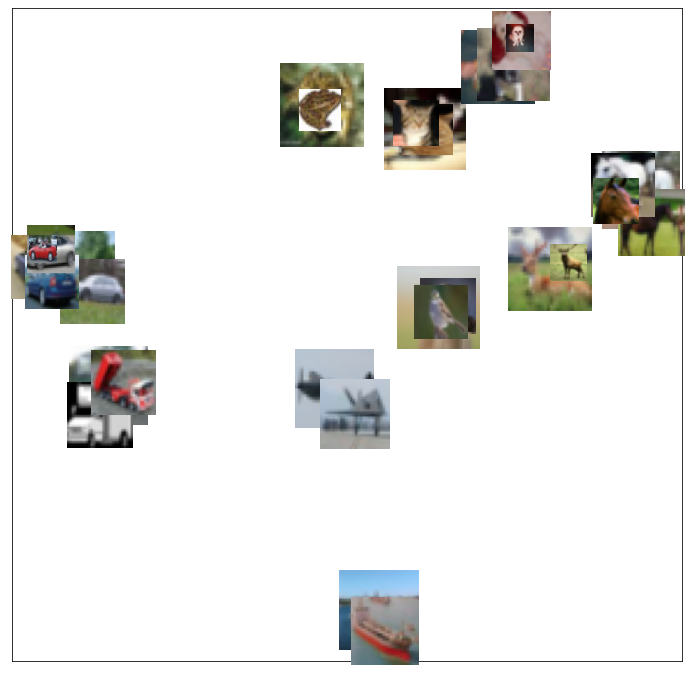

In [19]:
# display prototypes in 2D
ax = visualize_image_prototypes(summary=summary,
                                trainset=(X_train, y_train),
                                reducer=reducer.transform,
                                preprocess_fn=preprocess_fn,
                                knn_kw = {'metric': 'euclidean'},
                                fig_kw={'figwidth': 12, 'figheight': 12})

Besides visualizing and understanding the prototypes importance (i.e., larger images correspond to more important prototypes), one can also understand the diversity of each class by simply displaying all their corresponding prototypes. 

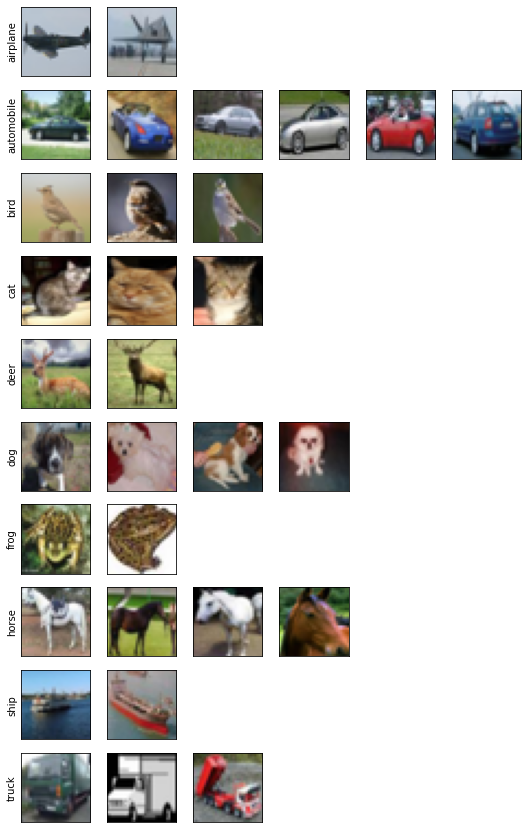

In [20]:
display_images(summary=summary, imgsize=1.5)

For example, within the current setup, we can observe that only two prototypes are required to cover the subset of the `airplane` instance.  On the other hand,  for the subset of the `car` instances, we need at least six prototypes. The visualization suggests that the `car` class has more diversity in the feature representation and implicitly requires more prototypes to cover its instances.

### Train 1-KNN

As before, we train a 1-KNN classifier to verify the quality of the prototypes returned by **ProtoSelect** against a random sampling.

In [21]:
# train 1-knn classifier using the selected prototypes
X_protos = summary.data['prototypes']
y_protos = summary.data['prototype_labels']
knn_proto = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn_proto = knn_proto.fit(X=preprocess_fn(X_protos), y=y_protos)

In [22]:
np.random.seed(0)
scores = []

for i in range(10):
    rand_idx = np.random.choice(len(X_train), size=len(X_protos), replace=False)
    rands, rands_labels = X_train[rand_idx], y_train[rand_idx]
    
    knn_rand = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn_rand = knn_rand.fit(X=preprocess_fn(rands), y=rands_labels)
    scores.append(knn_rand.score(preprocess_fn(X_test), y_test))

In [23]:
print('ProtoSelect 1-KNN accuracy: %.3f' % (knn_proto.score(preprocess_fn(X_test), y_test)))
print('Random 1-KNN mean accuracy: %.3f' % (np.mean(scores)))

ProtoSelect 1-KNN accuracy: 0.870
Random 1-KNN mean accuracy: 0.773
